In [1]:
!pip install transformers torch datasets shap pandas scikit-learn accelerate matplotlib codecarbon==2.4.2 lime

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# Load the dataset
splits = {'train': 'train.csv', 'test': 'test.csv'}
train_raw = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["train"])
test_raw = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["test"])

train_raw.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,stereotype_type,text,text_with_marker,category,data_source,label
0,profession,The illustrator had tower hands.,The illustrator had ===tower=== hands.,unrelated,stereoset_intrasentence,unrelated
1,profession,I gave that physician 5 stars because he was s...,I gave that physician 5 stars because he was s...,unrelated,stereoset_intrasentence,unrelated
2,nationality,Peru is a great place for a vacation the sky i...,Peru is a great place for a vacation ===the sk...,unrelated,stereoset_intersentence,unrelated
3,profession,That chef cooked a great meal. Throw that fur ...,That chef cooked a great meal. ===Throw that f...,unrelated,stereoset_intersentence,unrelated
4,nationality,Ecuadorian economy produces many toaster indiv...,Ecuadorian economy produces many ===toaster===...,unrelated,stereoset_intrasentence,unrelated


# Subsetting Data

In [4]:
# Use a subset of the data for faster training
sample_frac_train = 0.01
sample_frac_test = 0.01
train_data = train_raw.sample(frac=sample_frac_train, random_state=42)
test_data = test_raw.sample(frac=sample_frac_test, random_state=42)

# Prepare train and test sets by using both training and testing data
X_train, y_train = train_data["text"].values.tolist(), train_data["category"].values.tolist()
X_test, y_test = test_data["text"].values.tolist(), test_data["category"].values.tolist()

In [5]:
for t in train_data['stereotype_type'].unique():
  print(f"Type {t}: \n", train_data.loc[train_data['stereotype_type'] == t, 'category'].value_counts())

Type nationality: 
 category
neutral       73
stereotype    73
unrelated     57
Name: count, dtype: int64
Type lgbtq+: 
 category
neutral       8
stereotype    7
unrelated     7
Name: count, dtype: int64
Type gender: 
 category
neutral       21
stereotype    19
unrelated     18
Name: count, dtype: int64
Type profession: 
 category
stereotype    57
unrelated     53
neutral       47
Name: count, dtype: int64
Type race: 
 category
stereotype    4
Name: count, dtype: int64
Type religion: 
 category
stereotype    9
neutral       3
unrelated     2
Name: count, dtype: int64


In [6]:
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (458, 6)
Test data shape: (114, 6)


# Mapping

In [7]:
import random
from sklearn.metrics import f1_score
from datasets import Dataset
from codecarbon import EmissionsTracker

# Convert to Hugging Face dataset format
train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
test_dataset = Dataset.from_dict({"text": X_test, "label": y_test})

# Map labels to IDs
label2id = {
    'stereotype': 0,
    'unrelated': 1,
    'neutral': 2,
}

id2label = {v: k for k, v in label2id.items()}

def map_labels(example):
    example['label'] = label2id[example['label']]
    return example

# Apply the mapping to your dataset
train_dataset = train_dataset.map(map_labels)
test_dataset = test_dataset.map(map_labels)

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

# Albert V2 Model

In [8]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import numpy as np

# Load tokenizer - look into this
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

# Apply the tokenizer to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# make torch for efficiency
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Create DataLoaders for train and test sets
train_loader = DataLoader(tokenized_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_test_dataset, batch_size=16)

# Load pre-trained ALBERT model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=3,
    label2id=label2id,
    id2label=id2label
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "mps" For macOS (Apple Silicon)
print(f"Using device {device}")

# Model, optimizer, and loss function
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()


tracker = EmissionsTracker()
tracker.start()


epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
f1s = []
carbon_emissions = []

for num in epochs:
  for epoch in range(num):  # Number of epochs
      model.train()

      epoch_score = 0
      count = 0
      for batch in train_loader:
          # Move data to device
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["label"].to(device)

          # Forward pass
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Optionally compute and print metrics
          #logits = outputs.logits.detach().cpu().numpy()
          #label_ids = labels.to('cpu').numpy()
          #predictions = np.argmax(logits, axis=1)
          #f1 = f1_score(label_ids, predictions, average='macro')

  # Ensure your model is in evaluation mode
  model.eval()

  # Containers for true labels and predictions
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in test_loader:
        # Move inputs and labels to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass to get logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions by selecting the class with the highest score
        preds = torch.argmax(logits, dim=-1)

        # Move predictions and labels to CPU and convert to numpy arrays
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

  # Compute the F1 score
  f1_pred = f1_score(all_labels, all_preds, average='macro')

  print(f'epochs number {num} done.')

  emissions = tracker.stop()
  carbon_emissions.append(emissions)
  f1s.append(f1_pred)

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon WARNING @ 19:02:42] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 19:02:42] [setup] RAM Tracking...
[codecarbon INFO @ 19:02:42] [setup] GPU Tracking...
[codecarbon INFO @ 19:02:42] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:02:42] [setup] CPU Tracking...
[codecarbon WARNING @ 19:02:42] No CPU tracking mode found. Falling back on CPU constant mode.


Using device cuda


[codecarbon WARNING @ 19:02:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:02:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:02:43] >>> Tracker's metadata:
[codecarbon INFO @ 19:02:43]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 19:02:43]   Python version: 3.10.12
[codecarbon INFO @ 19:02:43]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 19:02:43]   Available RAM : 83.477 GB
[codecarbon INFO @ 19:02:43]   CPU count: 12
[codecarbon INFO @ 19:02:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:02:43]   GPU count: 1
[codecarbon INFO @ 19:02:43]   GPU model: 1 x NVIDIA A100-SXM4-40GB
[codecarbon INFO @ 19:02:55] Energy consumed for RAM : 0.000096 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:02:55] Energy consumed for all GPUs : 0.000826 kWh. Total GPU Power : 267.76752790269677 W
[codecarbon INFO @ 19:0

epochs number 1 done.


[codecarbon WARNING @ 19:03:14] Tracker already stopped !
[codecarbon INFO @ 19:03:14] Energy consumed for RAM : 0.000267 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:03:14] Energy consumed for all GPUs : 0.002432 kWh. Total GPU Power : 295.1078952803916 W
[codecarbon INFO @ 19:03:14] Energy consumed for all CPUs : 0.000362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:14] 0.003062 kWh of electricity used since the beginning.


epochs number 2 done.


[codecarbon WARNING @ 19:03:43] Tracker already stopped !
[codecarbon INFO @ 19:03:43] Energy consumed for RAM : 0.000518 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:03:43] Energy consumed for all GPUs : 0.004816 kWh. Total GPU Power : 296.8035483348627 W
[codecarbon INFO @ 19:03:43] Energy consumed for all CPUs : 0.000704 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:43] 0.006038 kWh of electricity used since the beginning.


epochs number 3 done.


[codecarbon WARNING @ 19:04:21] Tracker already stopped !
[codecarbon INFO @ 19:04:21] Energy consumed for RAM : 0.000851 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:04:21] Energy consumed for all GPUs : 0.007985 kWh. Total GPU Power : 298.04659766392905 W
[codecarbon INFO @ 19:04:21] Energy consumed for all CPUs : 0.001156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:21] 0.009992 kWh of electricity used since the beginning.


epochs number 4 done.


[codecarbon WARNING @ 19:05:09] Tracker already stopped !
[codecarbon WARNING @ 19:05:09] Background scheduler didn't run for a long period (47s), results might be inaccurate
[codecarbon INFO @ 19:05:09] Energy consumed for RAM : 0.001267 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:05:09] Energy consumed for all GPUs : 0.011932 kWh. Total GPU Power : 297.2480782421017 W
[codecarbon INFO @ 19:05:09] Energy consumed for all CPUs : 0.001720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:09] 0.014919 kWh of electricity used since the beginning.


epochs number 5 done.


[codecarbon WARNING @ 19:06:06] Tracker already stopped !
[codecarbon WARNING @ 19:06:06] Background scheduler didn't run for a long period (57s), results might be inaccurate
[codecarbon INFO @ 19:06:06] Energy consumed for RAM : 0.001763 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:06:06] Energy consumed for all GPUs : 0.016648 kWh. Total GPU Power : 297.33426430765496 W
[codecarbon INFO @ 19:06:06] Energy consumed for all CPUs : 0.002394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:06] 0.020806 kWh of electricity used since the beginning.


epochs number 6 done.


[codecarbon WARNING @ 19:07:13] Tracker already stopped !
[codecarbon WARNING @ 19:07:13] Background scheduler didn't run for a long period (66s), results might be inaccurate
[codecarbon INFO @ 19:07:13] Energy consumed for RAM : 0.002341 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:07:13] Energy consumed for all GPUs : 0.022141 kWh. Total GPU Power : 297.42848807074904 W
[codecarbon INFO @ 19:07:13] Energy consumed for all CPUs : 0.003179 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:07:13] 0.027661 kWh of electricity used since the beginning.


epochs number 7 done.


[codecarbon WARNING @ 19:08:29] Tracker already stopped !
[codecarbon WARNING @ 19:08:29] Background scheduler didn't run for a long period (75s), results might be inaccurate
[codecarbon INFO @ 19:08:29] Energy consumed for RAM : 0.003001 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:08:29] Energy consumed for all GPUs : 0.028416 kWh. Total GPU Power : 297.89885055376527 W
[codecarbon INFO @ 19:08:29] Energy consumed for all CPUs : 0.004075 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:08:29] 0.035492 kWh of electricity used since the beginning.


epochs number 8 done.


[codecarbon WARNING @ 19:09:54] Tracker already stopped !
[codecarbon WARNING @ 19:09:54] Background scheduler didn't run for a long period (85s), results might be inaccurate
[codecarbon INFO @ 19:09:54] Energy consumed for RAM : 0.003742 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:09:54] Energy consumed for all GPUs : 0.035463 kWh. Total GPU Power : 297.67125235576697 W
[codecarbon INFO @ 19:09:54] Energy consumed for all CPUs : 0.005081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:09:54] 0.044285 kWh of electricity used since the beginning.


epochs number 9 done.


[codecarbon WARNING @ 19:11:29] Tracker already stopped !
[codecarbon WARNING @ 19:11:29] Background scheduler didn't run for a long period (94s), results might be inaccurate
[codecarbon INFO @ 19:11:29] Energy consumed for RAM : 0.004565 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:11:29] Energy consumed for all GPUs : 0.043278 kWh. Total GPU Power : 297.2887856694479 W
[codecarbon INFO @ 19:11:29] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:29] 0.054040 kWh of electricity used since the beginning.


epochs number 10 done.


## Sustainability vs Performance by Epoch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

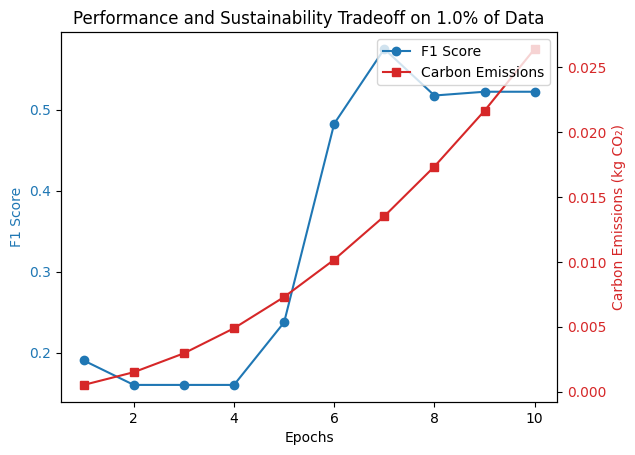

In [9]:
# Create a new figure and axis
fig, ax1 = plt.subplots()

# Plot F1 Score on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('F1 Score', color=color)
ax1.plot(epochs, f1s, color=color, marker='o', label='F1 Score')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot Carbon Emissions on the secondary y-axis
color = 'tab:red'
ax2.set_ylabel('Carbon Emissions (kg CO₂)', color=color)
ax2.plot(epochs, carbon_emissions, color=color, marker='s', label='Carbon Emissions')
ax2.tick_params(axis='y', labelcolor=color)

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Add a title
plt.title(f'Performance and Sustainability Tradeoff on {sample_frac_train*100}% of Data')

# Show the plot
plt.savefig('performance_and_sustainability.png')
files.download('performance_and_sustainability.png')
plt.show()

The ideal number of epochs is 6 or 7, but based off the scale on the left and the right one could argue that 6 epochs probably gives us the best tradeoff. The carbon emissions increases by 0.005kg CO2 with epochs, whereas the F1 score changes marginally. Now let's see how the performance and sustainability changes with batch size. By visualising both variables and how it changes we can find the optimal model.

## Sustainability vs Performance by Batch Size

In [8]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

# Apply the tokenizer to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


tracker = EmissionsTracker()
tracker.start()


batches = [4, 8, 16, 32, 64]
f1s = []
carbon_emissions = []

for num in batches:

  # make torch for efficiency
  tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
  tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  # Create DataLoaders for train and test sets
  train_loader = DataLoader(tokenized_train_dataset, batch_size=num, shuffle=True)
  test_loader = DataLoader(tokenized_test_dataset, batch_size=num)

  # Load pre-trained ALBERT model with classification head
  model = AutoModelForSequenceClassification.from_pretrained(
      "albert-base-v2",
      num_labels=3,
      label2id=label2id,
      id2label=id2label
  )

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "mps" For macOS (Apple Silicon)
  print(f"Using device {device}")

  # Model, optimizer, and loss function
  model.to(device)
  optimizer = AdamW(model.parameters(), lr=2e-5)
  criterion = CrossEntropyLoss()

  for epoch in range(6):
      model.train()

      for batch in train_loader:
          # Move data to device
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["label"].to(device)

          # Forward pass
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Optionally compute and print metrics
          #logits = outputs.logits.detach().cpu().numpy()
          #label_ids = labels.to('cpu').numpy()
          #predictions = np.argmax(logits, axis=1)
          #f1 = f1_score(label_ids, predictions, average='macro')

  # Ensure your model is in evaluation mode
  model.eval()

  # Containers for true labels and predictions
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in test_loader:
        # Move inputs and labels to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass to get logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions by selecting the class with the highest score
        preds = torch.argmax(logits, dim=-1)

        # Move predictions and labels to CPU and convert to numpy arrays
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

  # Compute the F1 score
  f1_pred = f1_score(all_labels, all_preds, average='macro')

  print(f'batches number {num} done.')

  emissions = tracker.stop()
  carbon_emissions.append(emissions)
  f1s.append(f1_pred)

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

[codecarbon WARNING @ 19:23:25] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 19:23:25] [setup] RAM Tracking...
[codecarbon INFO @ 19:23:25] [setup] GPU Tracking...
[codecarbon INFO @ 19:23:25] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:23:25] [setup] CPU Tracking...
[codecarbon WARNING @ 19:23:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:23:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:23:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:23:26] >>> Tracker's metadata:
[codecarbon INFO @ 19:23:26]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 19:23:26]   Python version: 3.10.12
[codecarbon INFO @ 19:23:27]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 19:23:27]   Available RAM : 83.477 GB
[codecarbon INFO @ 19:23:27]   CPU count: 12
[codecarbon INF

Using device cuda


[codecarbon INFO @ 19:23:42] Energy consumed for RAM : 0.000130 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:23:42] Energy consumed for all GPUs : 0.001062 kWh. Total GPU Power : 254.88039872143514 W
[codecarbon INFO @ 19:23:42] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:23:42] 0.001370 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:57] Energy consumed for RAM : 0.000261 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:23:57] Energy consumed for all GPUs : 0.002224 kWh. Total GPU Power : 278.9010057023637 W
[codecarbon INFO @ 19:23:57] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:23:57] 0.002839 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:24:12] Energy consumed for RAM : 0.000391 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:24:12] Energy consumed for all GPUs : 0.003395 kWh. Total GPU Power : 281.102742152751

batches number 4 done.


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device cuda


[codecarbon WARNING @ 19:25:31] Tracker already stopped !
[codecarbon WARNING @ 19:25:31] Background scheduler didn't run for a long period (60s), results might be inaccurate
[codecarbon INFO @ 19:25:31] Energy consumed for RAM : 0.001076 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:25:31] Energy consumed for all GPUs : 0.009360 kWh. Total GPU Power : 269.0233174571894 W
[codecarbon INFO @ 19:25:31] Energy consumed for all CPUs : 0.001461 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:25:31] 0.011897 kWh of electricity used since the beginning.


batches number 8 done.


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device cuda


[codecarbon WARNING @ 19:26:28] Tracker already stopped !
[codecarbon WARNING @ 19:26:28] Background scheduler didn't run for a long period (57s), results might be inaccurate
[codecarbon INFO @ 19:26:28] Energy consumed for RAM : 0.001576 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:26:28] Energy consumed for all GPUs : 0.014088 kWh. Total GPU Power : 295.7661913623202 W
[codecarbon INFO @ 19:26:28] Energy consumed for all CPUs : 0.002140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:28] 0.017805 kWh of electricity used since the beginning.


batches number 16 done.


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device cuda


[codecarbon WARNING @ 19:27:24] Tracker already stopped !
[codecarbon WARNING @ 19:27:24] Background scheduler didn't run for a long period (55s), results might be inaccurate
[codecarbon INFO @ 19:27:24] Energy consumed for RAM : 0.002060 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:27:24] Energy consumed for all GPUs : 0.018600 kWh. Total GPU Power : 291.7163499178293 W
[codecarbon INFO @ 19:27:24] Energy consumed for all CPUs : 0.002798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:24] 0.023459 kWh of electricity used since the beginning.


batches number 32 done.


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device cuda


[codecarbon WARNING @ 19:28:19] Tracker already stopped !
[codecarbon WARNING @ 19:28:19] Background scheduler didn't run for a long period (54s), results might be inaccurate
[codecarbon INFO @ 19:28:19] Energy consumed for RAM : 0.002537 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:28:19] Energy consumed for all GPUs : 0.023017 kWh. Total GPU Power : 290.1388329605713 W
[codecarbon INFO @ 19:28:19] Energy consumed for all CPUs : 0.003445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:19] 0.028999 kWh of electricity used since the beginning.


batches number 64 done.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

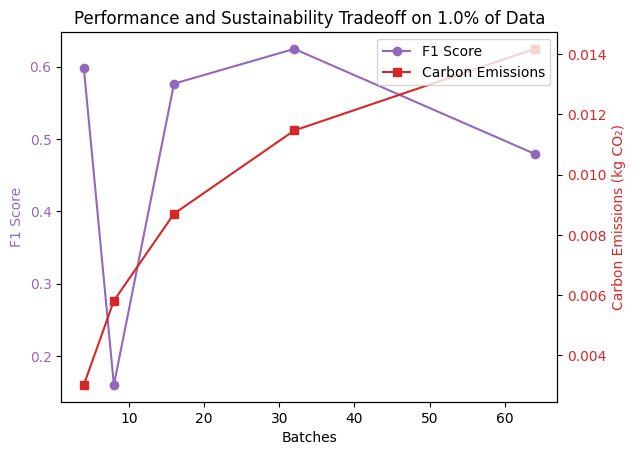

In [9]:
# Create a new figure and axis
fig, ax1 = plt.subplots()

# Plot F1 Score on the primary y-axis
color = 'tab:purple'
ax1.set_xlabel('Batches')
ax1.set_ylabel('F1 Score', color=color)
ax1.plot(batches, f1s, color=color, marker='o', label='F1 Score')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot Carbon Emissions on the secondary y-axis
color = 'tab:red'
ax2.set_ylabel('Carbon Emissions (kg CO₂)', color=color)
ax2.plot(batches, carbon_emissions, color=color, marker='s', label='Carbon Emissions')
ax2.tick_params(axis='y', labelcolor=color)

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Add a title
plt.title(f'Performance and Sustainability Tradeoff on {sample_frac_train*100}% of Data')

# Show the plot
plt.savefig('performance_and_sustainability_batches.png')
files.download('performance_and_sustainability_batches.png')
plt.show()

Once again we can argue that the best tradeoff occurs when the batch_size is 16. So the optimal model in terms of hyperparameters would be 6 epochs and a batch_size of 16, when training on 1% of the data.

## Optimal ALbert V2 Model

In [11]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

# Apply the tokenizer to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


tracker = EmissionsTracker()
tracker.start()

# make torch for efficiency
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Create DataLoaders for train and test sets
train_loader = DataLoader(tokenized_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_test_dataset, batch_size=16)

# Load pre-trained ALBERT model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=3,
    label2id=label2id,
    id2label=id2label
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "mps" For macOS (Apple Silicon)
print(f"Using device {device}")

# Model, optimizer, and loss function
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

for epoch in range(6):
    model.train()

    for batch in train_loader:
        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optionally compute and print metrics
        #logits = outputs.logits.detach().cpu().numpy()
        #label_ids = labels.to('cpu').numpy()
        #predictions = np.argmax(logits, axis=1)
        #f1 = f1_score(label_ids, predictions, average='macro')

emissions = tracker.stop()
print(f"The Carbon Emissions from the Training: {emissions}")

# Ensure your model is in evaluation mode
model.eval()

# Containers for true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in test_loader:
      # Move inputs and labels to device
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["label"].to(device)

      # Forward pass to get logits
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits

      # Get predictions by selecting the class with the highest score
      preds = torch.argmax(logits, dim=-1)

      # Move predictions and labels to CPU and convert to numpy arrays
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

# Compute the F1 score
f1_pred = f1_score(all_labels, all_preds, average='macro')
print(f"The F1-score from the Testing: {f1_pred}")

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

[codecarbon WARNING @ 19:37:27] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 19:37:27] [setup] RAM Tracking...
[codecarbon INFO @ 19:37:27] [setup] GPU Tracking...
[codecarbon INFO @ 19:37:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:37:27] [setup] CPU Tracking...
[codecarbon WARNING @ 19:37:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:37:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:37:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:37:29] >>> Tracker's metadata:
[codecarbon INFO @ 19:37:29]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 19:37:29]   Python version: 3.10.12
[codecarbon INFO @ 19:37:29]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 19:37:29]   Available RAM : 83.477 GB
[codecarbon INFO @ 19:37:29]   CPU count: 12
[codecarbon INF

Using device cuda


[codecarbon INFO @ 19:37:44] Energy consumed for RAM : 0.000130 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:37:44] Energy consumed for all GPUs : 0.001163 kWh. Total GPU Power : 279.0791105355115 W
[codecarbon INFO @ 19:37:44] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:44] 0.001471 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:59] Energy consumed for RAM : 0.000261 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:37:59] Energy consumed for all GPUs : 0.002399 kWh. Total GPU Power : 296.5761850721971 W
[codecarbon INFO @ 19:37:59] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:59] 0.003014 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:38:14] Energy consumed for RAM : 0.000391 kWh. RAM Power : 31.30389261245728 W
[codecarbon INFO @ 19:38:14] Energy consumed for all GPUs : 0.003635 kWh. Total GPU Power : 296.7154976097432

The Carbon Emissions from the Training: 0.0027963107447013945
The F1-score from the Testing: 0.5948340548340548


In [12]:
f1_pred_albert = f1_pred
emissions_albert = emissions

# Simple TF-IDF Model

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from codecarbon import EmissionsTracker

# TF-IDF Vectorizer
X_train = train_dataset['text']
y_train = train_dataset['label']
X_test = test_dataset['text']
y_test = test_dataset['label']

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression Model
model = LogisticRegression()

# Tracking emissions with CodeCarbon
tracker = EmissionsTracker()
tracker.start()

# Fit the model
model.fit(X_train_tfidf, y_train)

# Evaluate the model
predictions = model.predict(X_test_tfidf)
f1 = f1_score(y_test, predictions, average='macro')

emissions = tracker.stop()
print(f"F1 Score: {f1}")
print(f"Training carbon emissions: {emissions} kg")

[codecarbon WARNING @ 19:40:38] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 19:40:38] [setup] RAM Tracking...
[codecarbon INFO @ 19:40:38] [setup] GPU Tracking...
[codecarbon INFO @ 19:40:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:40:38] [setup] CPU Tracking...
[codecarbon WARNING @ 19:40:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:40:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:40:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:40:39] >>> Tracker's metadata:
[codecarbon INFO @ 19:40:39]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 19:40:39]   Python version: 3.10.12
[codecarbon INFO @ 19:40:39]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 19:40:39]   Available RAM : 83.477 GB
[codecarbon INFO @ 19:40:39]   CPU count: 12
[codecarbon INF

F1 Score: 0.373054400130495
Training carbon emissions: 1.1335152701511149e-06 kg


In [14]:
f1_tdidf = f1
emissions_tfidf = emissions

In [15]:
# Data for the table
data = {
    'Model': ['ALBERT v2', 'TF-IDF'],
    'F1 Score': [f1_pred_albert, f1_tdidf],  # Replace with your actual F1 scores
    'Carbon Emissions (kg CO₂)': [emissions_albert, emissions_tfidf]  # Replace with your actual emission values
}

# Create the DataFrame
df = pd.DataFrame(data)

# Set 'Model' as the index if you prefer
df.set_index('Model', inplace=True)
# Print the DataFrame
print(df)

           F1 Score  Carbon Emissions (kg CO₂)
Model                                         
ALBERT v2  0.594834                   0.002796
TF-IDF     0.373054                   0.000001


Let's see how much we can train on with the TD-IDF model to provide the same carbon emissions

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from codecarbon import EmissionsTracker

sample_frac_train = 1
sample_frac_test = 1
train_data_full = train_raw.sample(frac=sample_frac_train, random_state=42)
test_data_full = test_raw.sample(frac=sample_frac_test, random_state=42)

print(train_data_full.shape)
print(test_data_full.shape)

# Prepare train and test sets by using both training and testing data
# X_train_full, y_train_full = train_data_full["text"].values.tolist(), train_data_full["category"].values.tolist()
# X_test_full, y_test_full = test_data_full["text"].values.tolist(), test_data_full["category"].values.tolist()


# TF-IDF Vectorizer
X_train = train_data_full['text']
y_train = train_data_full['label']
X_test = test_data_full['text']
y_test = test_data_full['label']

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression Model
model = LogisticRegression()

# Tracking emissions with CodeCarbon
tracker = EmissionsTracker()
tracker.start()

# Fit the model
model.fit(X_train_tfidf, y_train)

# Evaluate the model
predictions = model.predict(X_test_tfidf)
f1_new = f1_score(y_test, predictions, average='macro')

emissions_new = tracker.stop()
print(f"F1 Score: {f1_new}")
print(f"Training carbon emissions: {emissions_new} kg")

(45760, 6)
(11441, 6)


[codecarbon WARNING @ 19:52:42] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 19:52:42] [setup] RAM Tracking...
[codecarbon INFO @ 19:52:42] [setup] GPU Tracking...
[codecarbon INFO @ 19:52:42] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:52:42] [setup] CPU Tracking...
[codecarbon WARNING @ 19:52:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:52:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:52:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:52:43] >>> Tracker's metadata:
[codecarbon INFO @ 19:52:43]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 19:52:43]   Python version: 3.10.12
[codecarbon INFO @ 19:52:43]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 19:52:43]   Available RAM : 83.477 GB
[codecarbon INFO @ 19:52:43]   CPU count: 12
[codecarbon INF

F1 Score: 0.4827560196450088
Training carbon emissions: 0.0005500000142415602 kg


We have the potential to train on so much more data and potentially improve the model - the following results were trained on the whole dataset! We are much more sustainable and only sacrifice a little performance

In [37]:
# Data for the table
data_new = {
    'Model_New': ['ALBERT v2', 'TF-IDF_FULL'],
    'F1 Score': [f1_pred_albert, f1_new],  # Replace with your actual F1 scores
    'Carbon Emissions (kg CO₂)': [emissions_albert, emissions_new]  # Replace with your actual emission values
}

# Create the DataFrame
df_new = pd.DataFrame(data_new)

# Set 'Model' as the index if you prefer
df_new.set_index('Model_New', inplace=True)
# Print the DataFrame
print(df_new)

             F1 Score  Carbon Emissions (kg CO₂)
Model_New                                       
ALBERT v2    0.594834                   0.002796
TF-IDF_FULL  0.482756                   0.000550


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

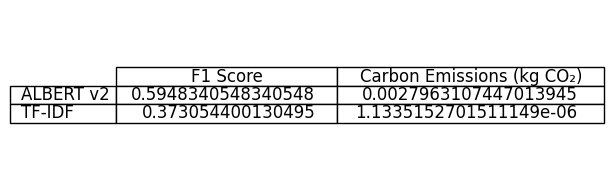

In [32]:
# Assuming 'df' is your DataFrame

# Set up a matplotlib figure
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Create the table
mpl_table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

# Adjust table properties
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(12)
mpl_table.auto_set_column_width(col=list(range(len(df.columns))))

# Save the figure
plt.tight_layout()
plt.savefig('model_comparison_table.png', dpi=300)
files.download('model_comparison_table.png')

# Show the table
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

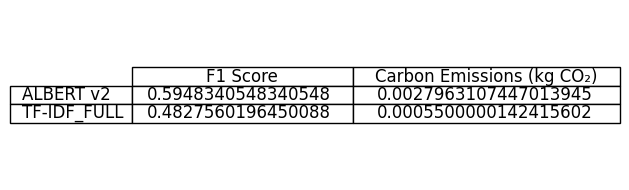

In [38]:
# Assuming 'df' is your DataFrame

# Set up a matplotlib figure
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Create the table
mpl_table = ax.table(cellText=df_new.values, colLabels=df_new.columns, rowLabels=df_new.index, loc='center')

# Adjust table properties
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(12)
mpl_table.auto_set_column_width(col=list(range(len(df.columns))))

# Save the figure
plt.tight_layout()
plt.savefig('model_comparison_table.png', dpi=300)
files.download('model_comparison_table.png')

# Show the table
plt.show()